In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score


In [2]:
data = pd.read_csv("creditcard.csv")
print("Null values:", data.isnull().values.any())
print("Label distribution:\n", data['Class'].value_counts())


Null values: False
Label distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


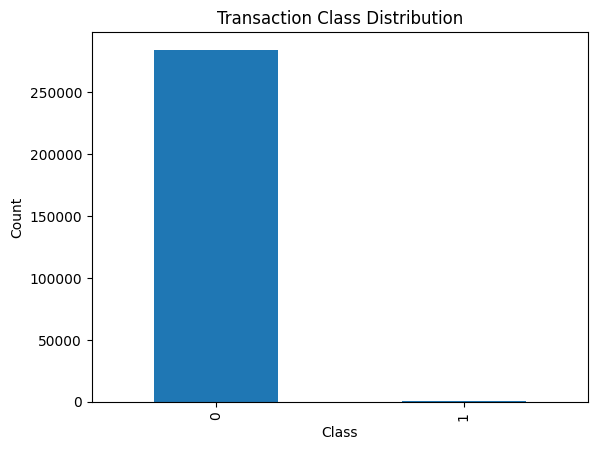

In [3]:
data['Class'].value_counts().plot(kind='bar', title="Transaction Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


In [4]:
scaler = StandardScaler()
data['Time'] = scaler.fit_transform(data['Time'].values.reshape(-1, 1))
data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))


In [5]:
X = data.drop(columns='Class')
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)


In [6]:
X_train_normal = X_train[y_train == 0]
X_test_normal = X_test[y_test == 0]
X_test_fraud = X_test[y_test == 1]


In [7]:
input_dim = X_train_normal.shape[1]
encoding_dim = 14
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-7


In [8]:
input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh", activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder = tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim, activation='relu')(encoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(encoder)
decoder = tf.keras.layers.Dense(input_dim, activation='tanh')(decoder)
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)


In [9]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = autoencoder.fit(X_train_normal, X_train_normal, epochs=10, batch_size=64, shuffle=True, validation_data=(X_test, X_test), verbose=1)


Epoch 1/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.3296 - loss: 0.8308 - val_accuracy: 0.4887 - val_loss: 0.7174
Epoch 2/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.4556 - loss: 0.7103 - val_accuracy: 0.4973 - val_loss: 0.6980
Epoch 3/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.4616 - loss: 0.6779 - val_accuracy: 0.4905 - val_loss: 0.6706
Epoch 4/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.4445 - loss: 0.6893 - val_accuracy: 0.4597 - val_loss: 0.6575
Epoch 5/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.4341 - loss: 0.6700 - val_accuracy: 0.4535 - val_loss: 0.6514
Epoch 6/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.4317 - loss: 0.6548 - val_accuracy: 0.4551 - val_loss: 0.6446
Epoch 7/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.4359 - loss: 0.6750 - val_accuracy: 0.4582 - val_loss: 0.6391
Epoch 8/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.4361 - loss: 0.64

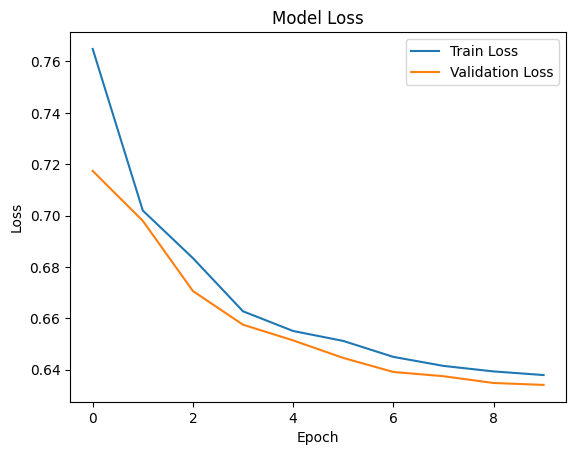

In [10]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [11]:
X_test_predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_test})


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


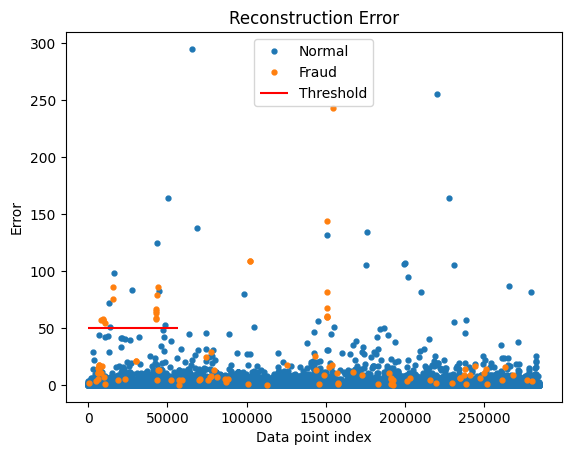

In [12]:
threshold = 50
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='', label="Fraud" if name == 1 else "Normal")
ax.hlines(threshold, xmin=0, xmax=len(error_df), colors="r", label="Threshold")
plt.title("Reconstruction Error")
plt.xlabel("Data point index")
plt.ylabel("Error")
plt.legend()
plt.show()


In [13]:
y_pred = [1 if e > threshold else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, y_pred)


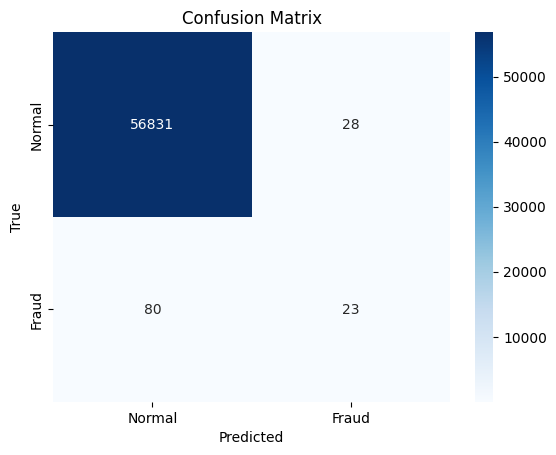

In [14]:
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Fraud"], yticklabels=["Normal", "Fraud"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [15]:
print("Accuracy:", accuracy_score(error_df['True_class'], y_pred))
print("Recall:", recall_score(error_df['True_class'], y_pred))
print("Precision:", precision_score(error_df['True_class'], y_pred))


Accuracy: 0.9981039991573329
Recall: 0.22330097087378642
Precision: 0.45098039215686275
